In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.concatenate((np.real(z), np.imag(z)))

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
## Constantes

horizonte = 3
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.80)],[complex(0.0,0.60)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(lambda z: funcaoObjetivo(real_to_complex(z), iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise),  x0=complex_to_real(x), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

In [4]:
## Constantes

horizonte = 4
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.80)],[complex(0.0,0.60)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos4 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo4 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda4[0][iteracao] = ondaOrigem[0][0]
    valoresOnda4[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes4[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes4[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(lambda z: funcaoObjetivo(real_to_complex(z), iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise),  x0=complex_to_real(x), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos4[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo4[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo4[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

In [5]:
## Constantes

horizonte = 5
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.80)],[complex(0.0,0.60)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos5 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo5 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda5[0][iteracao] = ondaOrigem[0][0]
    valoresOnda5[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes5[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes5[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(lambda z: funcaoObjetivo(real_to_complex(z), iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise),  x0=complex_to_real(x), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos5[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo5[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo5[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

### Avaliação da minimização

A fim de observar o poder da manipulação de horizontes, abaixo se faz a comparação entre os cálculos de minimização aumentando linearmente o horizonte.

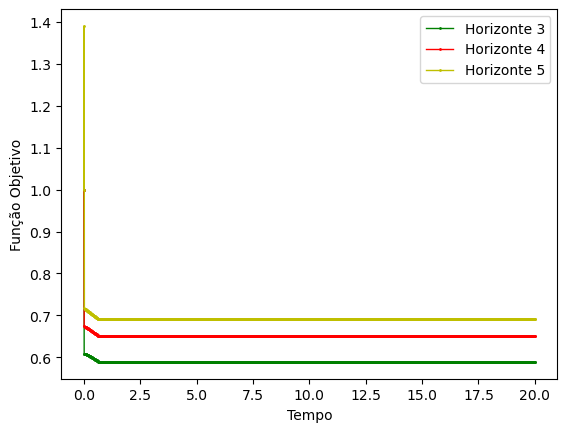

In [7]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0])/abs(valoresFuncaoObjetivo3[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(valoresFuncaoObjetivo4[0])/abs(valoresFuncaoObjetivo4[0][0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 4")
plt.plot(ts, abs(valoresFuncaoObjetivo5[0])/abs(valoresFuncaoObjetivo5[0][0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.legend(loc="upper right")
plt.show()

[432, 832, 1232, 1632, 1650]
[400, 800, 1200, 1600, 1999]
A defasagem da primeira componente é: [32, 32, 32, 32, -349]


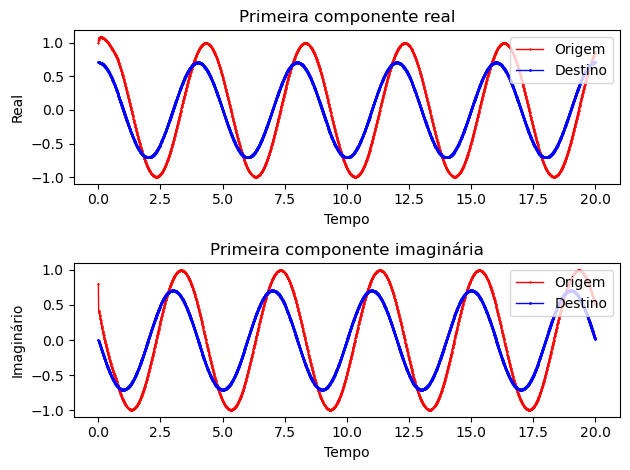

In [8]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()


### Avaliação do erro

diferencaAbsoluta3 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    diferencaAbsoluta3[0][i] = ((abs(valoresOnda3[0][i]) - abs(evolucaoDestino[0][i])))
    diferencaAbsoluta3[1][i] = ((abs(valoresOnda3[1][i]) - abs(evolucaoDestino[1][i])))


### Avaliação da defasagem

maximosOrigem = []
maximosDestino = []
for i in range(250, 2000, 350):
    maiorOrigem = []
    maiorDestino = []
    for j in range(i, i+350):
        maiorOrigem.append(realObjetivoPrimeiraComponente[j])
        maiorDestino.append(realDestinoPrimeiraComponente[j])
    maximosOrigem.append(np.max(maiorOrigem))
    maximosDestino.append(np.max(maiorDestino))

tempoOrigem = []
i = 250
j = 0
while i < 2000 and j < len(maximosOrigem):
    if (realObjetivoPrimeiraComponente[i] == maximosOrigem[j]):
        tempoOrigem.append(i)
        j+=1
    i+=1
        
print(tempoOrigem)

tempoDestino = []
i = 250
j = 0
while i < 2000 and j < len(maximosDestino):
    if (realDestinoPrimeiraComponente[i] == maximosDestino[j]):
        tempoDestino.append(i)
        j+=1
    i+=1
        
print(tempoDestino)

defasagem3 = []
for i in range(0, len(tempoDestino)):
    defasagem3.append(tempoOrigem[i] - tempoDestino[i])

print(f"A defasagem da primeira componente é: {defasagem3}")

[125, 256, 389, 522, 656, 789, 922, 1056, 1189, 1322, 1456, 1589, 1722, 1856, 1989]
[133, 267, 400, 533, 667, 800, 933, 1067, 1200, 1333, 1467, 1600, 1733, 1867, 1999]
A defasagem da segunda componente é: [-8, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11, -10]


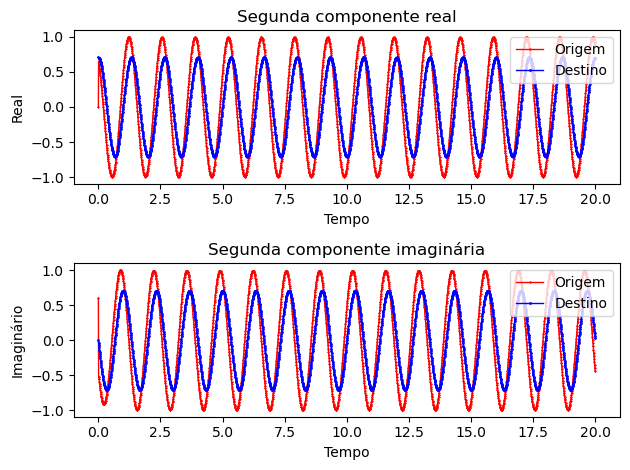

In [9]:
# Plotagem

plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Segunda componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Segunda componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

### Avaliação da defasagem

maximosOrigem = []
maximosDestino = []
for i in range(125, 2000, 125):
    maiorOrigem = []
    maiorDestino = []
    for j in range(i, i+125):
        maiorOrigem.append(realObjetivoSegundaComponente[j])
        maiorDestino.append(realDestinoSegundaComponente[j])
    maximosOrigem.append(np.max(maiorOrigem))
    maximosDestino.append(np.max(maiorDestino))

tempoOrigem = []
i = 100
j = 0
while i < 2000 and j < len(maximosOrigem):
    if (realObjetivoSegundaComponente[i] == maximosOrigem[j]):
        tempoOrigem.append(i)
        j+=1
    i+=1
        
print(tempoOrigem)

tempoDestino = []
i = 100
j = 0
while i < 2000 and j < len(maximosDestino):
    if (realDestinoSegundaComponente[i] == maximosDestino[j]):
        tempoDestino.append(i)
        j+=1
    i+=1
        
print(tempoDestino)

defasagem3 = []
for i in range(0, len(tempoDestino)):
    defasagem3.append(tempoOrigem[i] - tempoDestino[i])

print(f"A defasagem da segunda componente é: {defasagem3}")

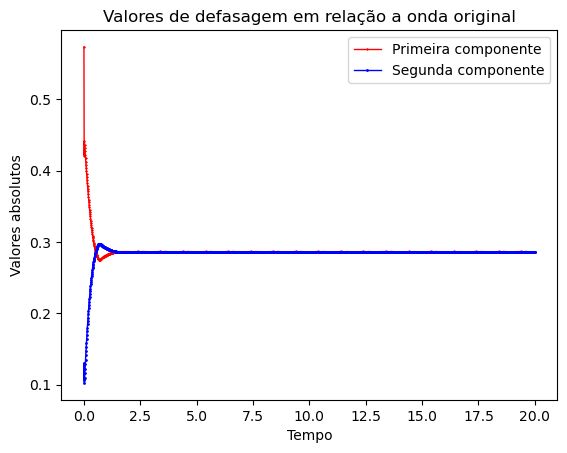

In [10]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(diferencaAbsoluta3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(diferencaAbsoluta3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

In [11]:
from scipy.integrate import trapz

# Processo de integração numérica usando o método dos trapézios

x=np.linspace(0,20,2000) # Espaçamento

Integral = trapz(diferencaAbsoluta3[0],x) # Primeira componente

print(Integral)

Integral = trapz(diferencaAbsoluta3[1],x) # Segunda componente

print(Integral)

(5.758685862229921+0j)
(5.694954075084283+0j)


NameError: name 'valoresOnda10' is not defined

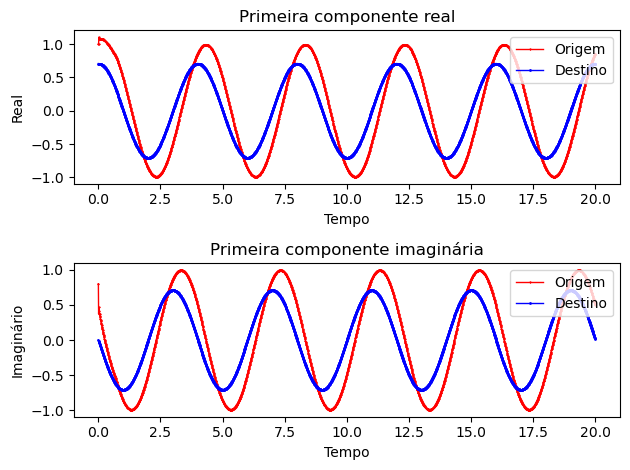

In [12]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda5[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda5[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda5[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda5[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

### Avaliação do erro

diferencaAbsoluta10 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    diferencaAbsoluta10[0][i] = ((abs(valoresOnda10[0][i]) - abs(evolucaoDestino[0][i])))
    diferencaAbsoluta10[1][i] = ((abs(valoresOnda10[1][i]) - abs(evolucaoDestino[1][i])))

### Avaliação da defasagem

maximosOrigem = []
maximosDestino = []
for i in range(250, 2000, 350):
    maiorOrigem = []
    maiorDestino = []
    for j in range(i, i+350):
        maiorOrigem.append(realObjetivoPrimeiraComponente[j])
        maiorDestino.append(realDestinoPrimeiraComponente[j])
    maximosOrigem.append(np.max(maiorOrigem))
    maximosDestino.append(np.max(maiorDestino))

tempoOrigem = []
i = 250
j = 0
while i < 2000 and j < len(maximosOrigem):
    if (realObjetivoPrimeiraComponente[i] == maximosOrigem[j]):
        tempoOrigem.append(i)
        j+=1
    i+=1
        
print(tempoOrigem)

tempoDestino = []
i = 250
j = 0
while i < 2000 and j < len(maximosDestino):
    if (realDestinoPrimeiraComponente[i] == maximosDestino[j]):
        tempoDestino.append(i)
        j+=1
    i+=1
        
print(tempoDestino)

defasagem5 = []
for i in range(0, len(tempoDestino)):
    defasagem5.append(tempoOrigem[i] - tempoDestino[i])

print(f"A defasagem da primeira componente é: {defasagem5}")

[125, 256, 389, 522, 656, 789, 922, 1056, 1189, 1322, 1456, 1589, 1722, 1856, 1989]
[133, 267, 400, 533, 667, 800, 933, 1067, 1200, 1333, 1467, 1600, 1733, 1867, 1999]
A defasagem da segunda componente é: [-8, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11, -10]


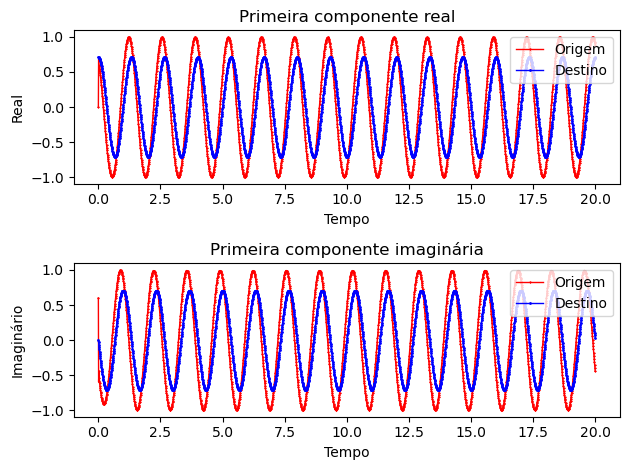

In [13]:
# Plotagem

plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

### Avaliação da defasagem

maximosOrigem = []
maximosDestino = []
for i in range(125, 2000, 125):
    maiorOrigem = []
    maiorDestino = []
    for j in range(i, i+125):
        maiorOrigem.append(realObjetivoSegundaComponente[j])
        maiorDestino.append(realDestinoSegundaComponente[j])
    maximosOrigem.append(np.max(maiorOrigem))
    maximosDestino.append(np.max(maiorDestino))

tempoOrigem = []
i = 100
j = 0
while i < 2000 and j < len(maximosOrigem):
    if (realObjetivoSegundaComponente[i] == maximosOrigem[j]):
        tempoOrigem.append(i)
        j+=1
    i+=1
        
print(tempoOrigem)

tempoDestino = []
i = 100
j = 0
while i < 2000 and j < len(maximosDestino):
    if (realDestinoSegundaComponente[i] == maximosDestino[j]):
        tempoDestino.append(i)
        j+=1
    i+=1
        
print(tempoDestino)

defasagem5 = []
for i in range(0, len(tempoDestino)):
    defasagem5.append(tempoOrigem[i] - tempoDestino[i])

print(f"A defasagem da segunda componente é: {defasagem5}")

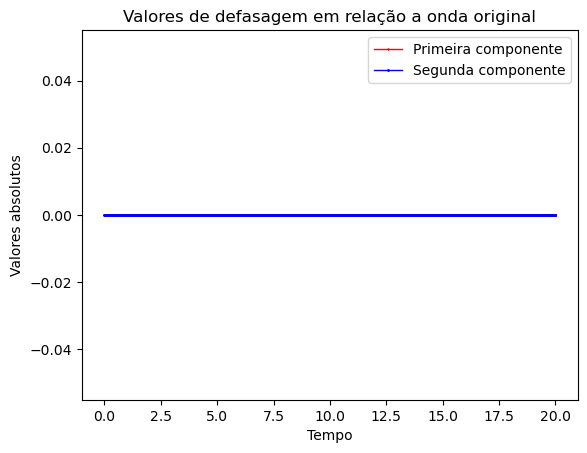

In [14]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(diferencaAbsoluta10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(diferencaAbsoluta10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

In [15]:
from scipy.integrate import trapz

# Processo de integração numérica usando o método dos trapézios

x=np.linspace(0,20,2000) # Espaçamento

Integral = trapz(diferencaAbsoluta10[0],x)

print(Integral)

Integral = trapz(diferencaAbsoluta10[1],x)

print(Integral)

0j
0j


### Avaliação das constantes



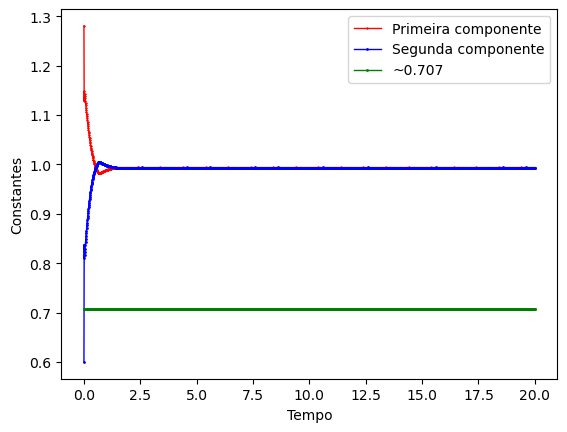

In [16]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

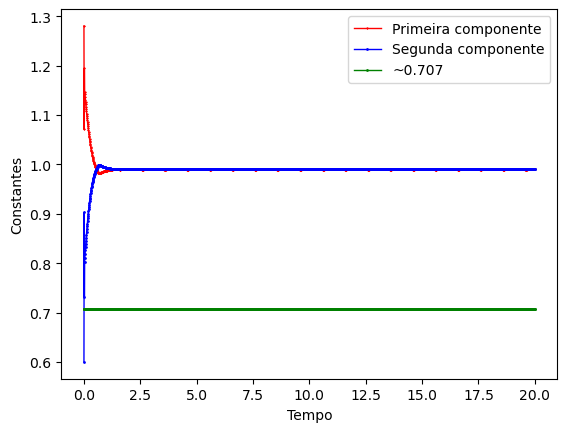

In [18]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes5[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes5[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

### Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

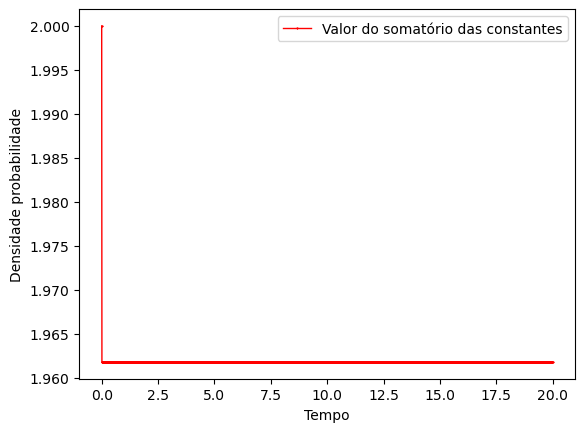

In [21]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(constantes5[0][i])**2+abs(constantes5[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
plt.savefig('dp.png', format='png')
plt.show()

In [23]:
import cmath

for i in range(0,2000):
    print(cmath.polar(valoresOnda5[0][i]/evolucaoDestino[0][i]))

(1.8110770276274837, 0.6747409422235527)
(1.514376151186095, 0.36982960352143074)
(1.6893121898932022, 0.4302347451827049)
(1.6227370346650967, 0.40873637030852766)
(1.6146951501096423, 0.40636286393608223)
(1.6071681136306777, 0.4043203303100808)
(1.599963979350109, 0.40253157527289085)
(1.592936576528793, 0.4009445807047049)
(1.5860133200554816, 0.3995331850154366)
(1.579207506958703, 0.39829240414388756)
(1.5724675042920928, 0.3972065800380377)
(1.5659229546262599, 0.39628927558122296)
(1.5595075418328006, 0.3955230534422736)
(1.5530484170761323, 0.3948844918813247)
(1.5467806378304703, 0.39439315143255305)
(1.540758546671358, 0.3940440462941402)
(1.5347914535634395, 0.39381995185653784)
(1.528850900908672, 0.3937183647377891)
(1.5232236464767033, 0.3937377063843305)
(1.5175366584449517, 0.39387477040741314)
(1.5119041412019476, 0.39412787343406797)
(1.5068413856528715, 0.3944619027563591)
(1.5014141896768534, 0.3949355566925465)
(1.4963582478822652, 0.39548600394140077)
(1.49149088

In [24]:
import cmath

for i in range(0,2000):
    print(cmath.polar(valoresOnda5[1][i]/evolucaoDestino[1][i]))

(0.848528137423857, 1.5707963267948966)
(1.276836313868675, -0.6716276907413714)
(1.0343447499387914, -0.5548881128861631)
(1.1359441932547751, -0.6051481978707742)
(1.1473466197034736, -0.6099209178389259)
(1.157866722791963, -0.6139116629759649)
(1.1678013348600715, -0.6173140323142694)
(1.1773689972904715, -0.6202563682207656)
(1.18667874378045, -0.6228090882725589)
(1.1957208461898245, -0.62499977119456)
(1.2045707283965292, -0.6268723023511775)
(1.2130663591329263, -0.628418516529297)
(1.221302959210422, -0.6296819171003335)
(1.2295061224537882, -0.6307122662716769)
(1.2373820546195171, -0.6314884395962765)
(1.2448726004100747, -0.6320288749117471)
(1.2522219788013478, -0.6323691201317606)
(1.2594679879408919, -0.6325205517172562)
(1.2662679070429192, -0.6324925626555046)
(1.2730778372132723, -0.6322962790851809)
(1.2797619141387506, -0.6319400918626102)
(1.2857191479039032, -0.6314777976841603)
(1.2920526767811682, -0.6308329546804007)
(1.2979047277340208, -0.6300957009080856)
(1

In [25]:
for i in range(0,2000):
    print(cmath.polar(valoresOnda3[0][i]/evolucaoDestino[0][i]))

(1.8110770276274837, 0.6747409422235527)
(1.5953740559745189, 0.39667169429005)
(1.6240185574717105, 0.4065165048130717)
(1.6172245409992974, 0.40434864675457666)
(1.6103528732970214, 0.40232415794418425)
(1.6038490437928608, 0.40056203224571935)
(1.597219109201183, 0.39891824467700143)
(1.5906733470019259, 0.39744213554898417)
(1.5837474722677283, 0.3960322614044797)
(1.5773274496775975, 0.39486360629043776)
(1.5711213172410974, 0.39386549924147124)
(1.565301164939113, 0.39305135852586626)
(1.5592000351797586, 0.39232439780634026)
(1.5529612315592214, 0.3917093531891977)
(1.5470064421098355, 0.39124417730989175)
(1.541224031105634, 0.3909105194022189)
(1.5357039792099059, 0.39070465850428066)
(1.5300776516682502, 0.39060985987256247)
(1.5245477130654, 0.3906301747967339)
(1.5191190720852574, 0.39076219779532395)
(1.5137099605968216, 0.39100632588933293)
(1.5084989583034514, 0.39135105932788267)
(1.503401191089063, 0.39179674702868666)
(1.4984326323836428, 0.39233830034132305)
(1.49354

In [26]:
import cmath

for i in range(0,2000):
    print(cmath.polar(valoresOnda3[1][i]/evolucaoDestino[1][i]))

(0.848528137423857, 1.5707963267948966)
(1.1846445036259527, -0.6261656501469619)
(1.1450610038880953, -0.6073731401295619)
(1.1546366360545828, -0.6116802780977387)
(1.1642012714681986, -0.615603178684064)
(1.1731450129692196, -0.6189360202838652)
(1.1821556977142922, -0.6219728869212844)
(1.1909488986868844, -0.6246371584090274)
(1.2001437080353463, -0.6271226629570021)
(1.208569026601582, -0.6291358487250347)
(1.2166259827072208, -0.6308184490534281)
(1.224105076394566, -0.6321631870629808)
(1.2318669672633091, -0.6333401336939684)
(1.2397227059857796, -0.6343156558637667)
(1.2471455577681578, -0.6350387819341754)
(1.2542844413698822, -0.6355476293871063)
(1.2610369787962834, -0.635855931579856)
(1.2678577811609295, -0.6359955094568119)
(1.2745019590825155, -0.6359664232802746)
(1.280967687991788, -0.6357793649350617)
(1.2873550900107205, -0.6354391659795072)
(1.2934573302276124, -0.6349666304146417)
(1.299379017334956, -0.6343654231150155)
(1.3051055964951728, -0.6336462010737293)
